<a href="https://colab.research.google.com/github/saadz-khan/Text2Image/blob/master/pixray_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

## Installation Only Once
Kindly check if you drive is connected by following the gif in the pdf file sent to you

In [2]:
import os
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. You should only need to run this part once.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

#@markdown When complete you will need to do Runtime -> Restart Runtime from the menu

# Add a gpu check
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  print(f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, some things might not work <--")
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

print("Installing...")
if os.path.exists('/content/drive/MyDrive/pixray'):
  pass
else:
    %mkdir /content/drive/MyDrive/pixray
%cd /content/drive/MyDrive/pixray
from IPython.utils import io
with io.capture_output() as captured:
  !rm -Rf pixray
  !git clone --recursive https://github.com/pixray/pixray
  #!pip install -r pixray/requirements.txt
  #!pip uninstall -y tensorflow 
  !git clone https://github.com/pixray/diffvg
  #%cd diffvg
  #!git submodule update --init --recursive
  #!python setup.py install
  #%cd ..
  #!pip freeze | grep torch
  !mkdir -p models

GPU check: 16280 MiB available: this should be fine
Installing...
/content/drive/MyDrive/pixray


In [3]:
#@title Installing and loading libraries 
#@markdown [Important Step] Please choose Runtime -> Restart Runtime from the menu after the installation! 
%cd /content/drive/MyDrive/pixray
from IPython.utils import io
with io.capture_output() as captured:
  !pip install -r pixray/requirements.txt
  !pip uninstall -y tensorflow 
  %cd diffvg
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..
  !pip freeze | grep torch

/content/drive/MyDrive/pixray


# main

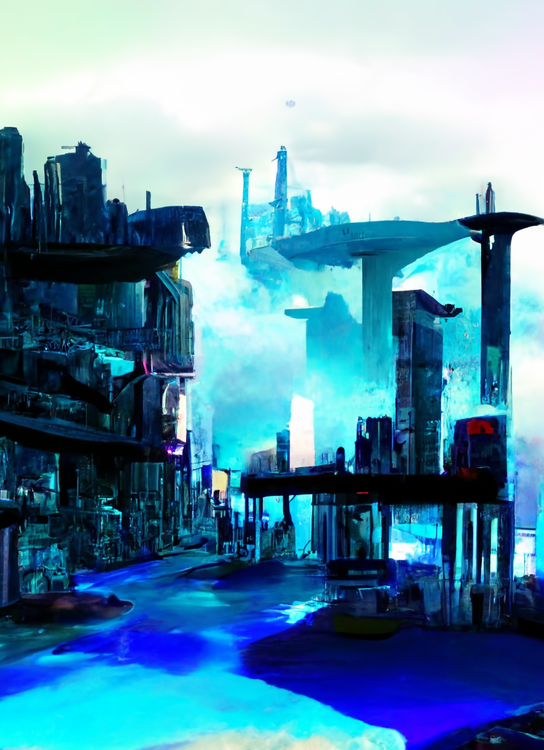

iter: 100, finished (-17=>6.032)



True

In [4]:
#@title Generate image from prompt { vertical-output: true }
import sys
import regex as re
import os
sys.path.append("pixray")
%cd /content/drive/MyDrive/pixray
import pixray


punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

prompts = "Cyberpunk | matte painting" #@param {type:"string"}

no_punct = ""
for char in prompts:
   if char not in punctuations:
       no_punct = no_punct + char

init_image = ""#@param {type:"string"}
if os.path.isfile(init_image):
  pass
else: init_image = None

#init_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)
#init_image = re.findall('^/[\w\.\-]+$', init_image)

#target_image = ""#@param {type:"string"}
#target_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)

drawer = "vdiff" #@param ["vqgan", "pixel", "vdiff"]

width = 544 #@param{type:"number"}
height = 750 #@param{type:"number"}

video = False #@param {type:"boolean"}

display_clear = True #@param {type:"boolean"}

iterations = 100 #@param {type:"number"}

quality = 'supreme' #@param ["normal", "better", "best", "supreme"]

#pixel_scale = 1 #@param {type:"slider", min:0.25, max:2.0, step:0.25}

num_cuts = 20 #@param {type:"slider", min:8, max:32, step:4}

batches = 1 #@param{type:"number"}
#clip_models = #@param ["RN101","RN50x4","ViT-B/16", "ViT-B/32", "all"]

custom_loss = 'none' #@param ['aesthetic', 'none']

#if clip_models == "all":
  #clip_models = ["RN101","RN50x4","ViT-B/16", "ViT-B/32"]

optimiser = 'Adam' #@param ["Adam", "DiffGrad"]

palette = False #@param {type:"boolean"}
if palette:
  use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}
  pixray.add_settings(target_palette=use_palette)

pixray.reset_settings()
pixray.add_settings(prompts=prompts)
pixray.add_settings(quality=quality,
                    size=[width,height],
                    iterations=iterations,
                    drawer=drawer,
                    display_clear=display_clear,
                    make_video=video,
                    optimiser = optimiser,
                    init_image = init_image,
                    batches = batches,
                    num_cuts = 8,
                    output = no_punct
                    )

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)


## Animation part:
Like the ones before can be implemented as well but not currently deployed and ready for you

In [ ]:
import torch
torch.cuda.empty_cache()

import shutil
# shutil.copy("output.png","3d-photo-inpainting/image")

from PIL import Image
import os
import glob
for f in glob.glob("3d-photo-inpainting/image/*.*"):
    os.remove(f)
im = Image.open(settings.output)
im.save(f"3d-photo-inpainting/image/input.jpg")


import time
begin = time.time()
for f in glob.glob("3d-photo-inpainting/video/*.*"):
    os.remove(f)
%cd 3d-photo-inpainting 
!python main.py --config argument.yml
%cd ..
print(f"finished in {time.time() - begin}")


from IPython import display
import glob
from PIL import Image
from IPython.display import HTML
from base64 import b64encode
from IPython.utils import io

fps = glob.glob("3d-photo-inpainting/video/*")
for f in fps:
    mp4 = open(f,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    # display.clear_output()
    display.display(HTML("""
    <video height=350 controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))